In [1]:
import matplotlib.pyplot as plt
import numpy as np
data = np.load("validation_trace.npz")
example = data["raw"]
ampl_arr = data["ampl"]
chisq_arr = data["chisq"]
idx = data["inject"].item()  

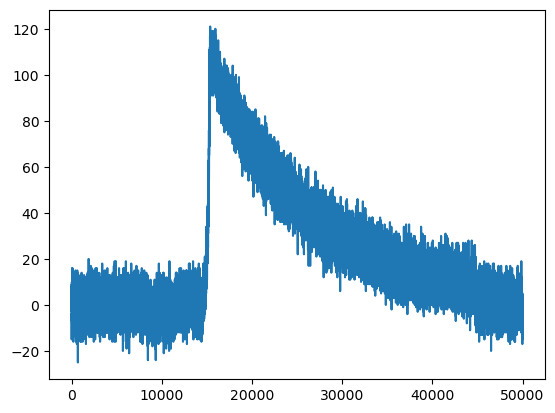

In [5]:
plt.plot(example)

In [6]:
len(ampl_arr)

17233

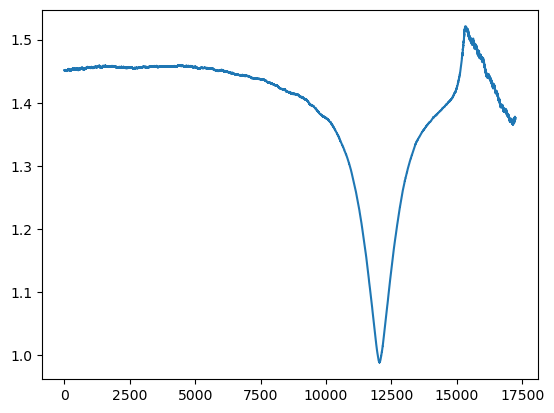

In [7]:
plt.plot(chisq_arr)

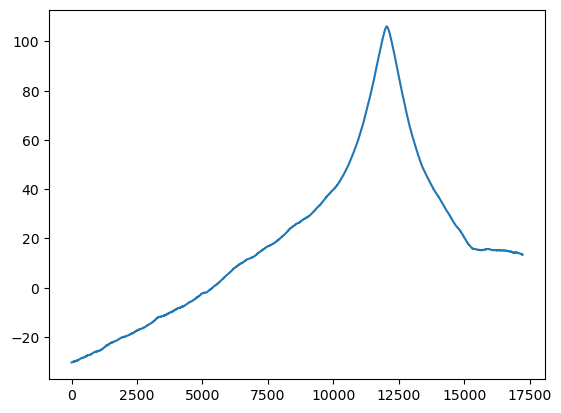

In [8]:
plt.plot(ampl_arr)

Global optimum filter completed in 0.0040 seconds.


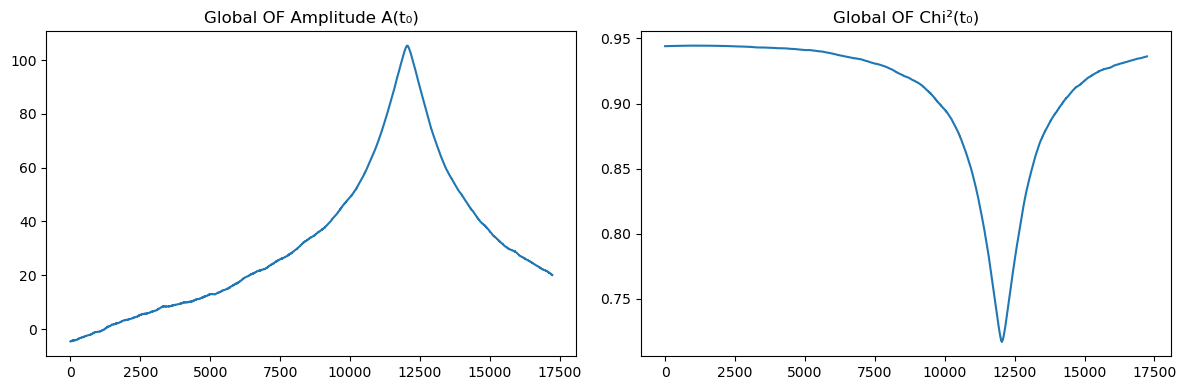

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
length = len(template)
# Global Optimum Filter (frequency-domain)

L_example = len(example)
L_temp = len(template)

# 1. Pad template to match trace
template_padded = np.pad(template, (0, L_example - L_temp))

# 2. FFT of template and trace
template_fft = fft(template_padded) / sampling_frequency
example_fft = fft(example) / sampling_frequency

# 3. Unfold noise PSD to full length
if L_example % 2 == 0:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:-1] / 2,
        [noise_psd[-1]],
        noise_psd[-2:0:-1] / 2
    ))
else:
    noise_psd_unfolded = np.concatenate((
        [1e30],
        noise_psd[1:] / 2,
        noise_psd[-1:0:-1] / 2
    ))
noise_psd_unfolded = np.pad(noise_psd_unfolded, (0, L_example - len(noise_psd_unfolded)))

# Avoid divide-by-zero or inf
noise_psd_unfolded = np.where(noise_psd_unfolded == 0, 1e30, noise_psd_unfolded)

# 4. Build filter kernel
kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft)) * sampling_frequency / L_example
filter_kernel_fft = kernel_fft / kernel_normalization
start_time = time.perf_counter()

# 5. Apply to full trace
filtered_fft = example_fft * filter_kernel_fft
amp_t0_global = np.real(ifft(filtered_fft)) * sampling_frequency

# 6. Estimate chi^2(t0)
power_fft = example_fft.conj() * example_fft / noise_psd_unfolded
chi0_global = np.real(np.sum(power_fft)) * sampling_frequency / L_example
chit_withdelay = amp_t0_global**2 * kernel_normalization
chi2_t0_global = (chi0_global - chit_withdelay) / (L_example - 3)  # normalize by DOF

elapsed_time = time.perf_counter() - start_time
print(f"Global optimum filter completed in {elapsed_time:.4f} seconds.")

# Optional visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(amp_t0_global[:17233])
plt.title("Global OF Amplitude A(t₀)")
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_global[:17233])
plt.title("Global OF Chi²(t₀)")
plt.tight_layout()
plt.show()

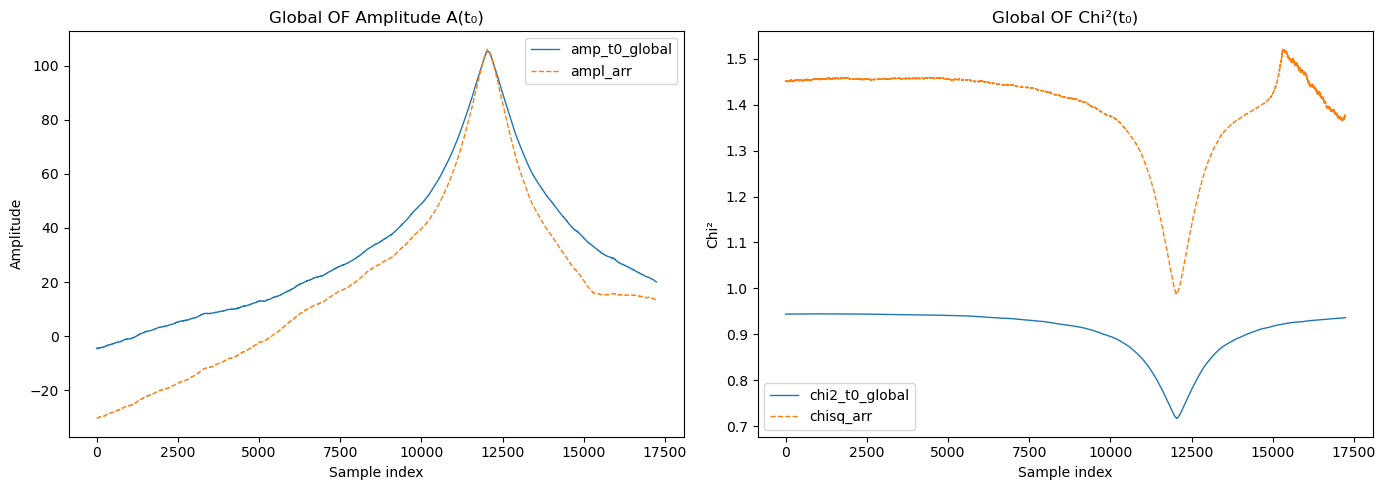

In [12]:
length = min(len(amp_t0_global), len(ampl_arr), 17233)

plt.figure(figsize=(14, 5))

# Plot Amplitude comparison
plt.subplot(1, 2, 1)
plt.plot(amp_t0_global[:length], label="amp_t0_global", linewidth=1)
plt.plot(ampl_arr[:length], label="ampl_arr", linewidth=1, linestyle='--')
plt.title("Global OF Amplitude A(t₀)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.legend()

# Plot Chi² comparison
plt.subplot(1, 2, 2)
plt.plot(chi2_t0_global[:length], label="chi2_t0_global", linewidth=1)
plt.plot(chisq_arr[:length], label="chisq_arr", linewidth=1, linestyle='--')
plt.title("Global OF Chi²(t₀)")
plt.xlabel("Sample index")
plt.ylabel("Chi²")
plt.legend()

plt.tight_layout()
plt.show()